# Install & Import Packages 

In [43]:
# Instalar librerías (ejecutar sólo la primera vez)
# %pip install torch scikit-learn matplotlib

In [61]:
# Importar librerías
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Task 1 - Preparación del conjunto de datos

Cargue el conjunto de datos de Iris utilizando bibliotecas como sklearn.datasets. Luego, divida el conjunto de datos en conjuntos de entrenamiento y validación.

In [45]:
iris = load_iris()
x, y = iris.data, iris.target
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=43)
print(f'Número de características: {len(x[0])}')
print(f'Cantidad de datos de entrenamiento: {len(x_train)}')
print(f'Cantidad de datos de prueba: {len(x_val)}')
print(f'Tamaño total del conjunto: {len(x)}')

Número de características: 4
Cantidad de datos de entrenamiento: 105
Cantidad de datos de prueba: 45
Tamaño total del conjunto: 150


# Task 2 - Arquitectura modelo

Cree una red neuronal feedforward simple utilizando nn.Module de PyTorch. Luego, defina capa de entrada, capas ocultas y capa de salida. Después, elija las funciones de activación y el número de neuronas por capa.

In [46]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self):
        super(SimpleFeedForwardNN, self).__init__()
        
        # Capa de entrada
        self.input_layer = nn.Linear(4, 10)  # 4 características de entrada y 10 neuronas en la capa oculta
        
        # Capa oculta
        self.hidden_layer = nn.Linear(10, 10)  # 10 neuronas en la capa oculta y 10 en la siguiente
        
        # Capa de salida
        self.output_layer = nn.Linear(10, 3)  # 10 neuronas en la capa oculta y 3 neuronas de salida
        
    def forward(self, x):
        # Pasar la entrada a través de la capa de entrada y luego aplicar ReLU
        x = nn.ReLU()(self.input_layer(x))
        
        # Pasar la salida anterior a través de la capa oculta y luego aplicar ReLU
        x = nn.ReLU()(self.hidden_layer(x))
        
        # Pasar la salida anterior a través de la capa de salida
        # Nota: No aplicamos Softmax aquí porque durante el entrenamiento utilizaremos
        # CrossEntropyLoss que ya aplica Softmax.
        return self.output_layer(x)
        


# Task 3 - Funciones de Pérdida

Entrene el modelo con diferentes funciones de pérdida (al menos tres distintas) y registre las pérdidas de entrenamiento y test.

In [47]:
scaler = StandardScaler()

X = torch.tensor(scaler.fit_transform(x), dtype=torch.float32)
Y = torch.tensor(y, dtype=torch.int64)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

model = SimpleFeedForwardNN()
print(model.parameters())

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss(),
    "SmoothL1Loss": nn.SmoothL1Loss()
}

def evaluate_model(model, criterion, test_loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            
            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()

            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)


for name, criterion in loss_functions.items():
    model.apply(lambda m: m.reset_parameters() if type(m) == nn.Linear else None)  # Re-establecer los parámetros del modelo
    
    for epoch in range(50):
        model.train()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)

            if name in ["MSELoss", "SmoothL1Loss"]:
                targets = torch.nn.functional.one_hot(targets, 3).float()
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        test_loss = evaluate_model(model, criterion, test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}")


<generator object Module.parameters at 0x000001FCE922C120>
Epoch 1 [CrossEntropy] - Training Loss: 1.1241, Test Loss: 1.1262
Epoch 2 [CrossEntropy] - Training Loss: 1.1145, Test Loss: 1.1188
Epoch 3 [CrossEntropy] - Training Loss: 1.1071, Test Loss: 1.1123
Epoch 4 [CrossEntropy] - Training Loss: 1.1075, Test Loss: 1.1064
Epoch 5 [CrossEntropy] - Training Loss: 1.0935, Test Loss: 1.0999
Epoch 6 [CrossEntropy] - Training Loss: 1.0905, Test Loss: 1.0933
Epoch 7 [CrossEntropy] - Training Loss: 1.0856, Test Loss: 1.0866
Epoch 8 [CrossEntropy] - Training Loss: 1.0785, Test Loss: 1.0798
Epoch 9 [CrossEntropy] - Training Loss: 1.0756, Test Loss: 1.0727
Epoch 10 [CrossEntropy] - Training Loss: 1.0701, Test Loss: 1.0651
Epoch 11 [CrossEntropy] - Training Loss: 1.0576, Test Loss: 1.0571
Epoch 12 [CrossEntropy] - Training Loss: 1.0500, Test Loss: 1.0486
Epoch 13 [CrossEntropy] - Training Loss: 1.0456, Test Loss: 1.0400
Epoch 14 [CrossEntropy] - Training Loss: 1.0349, Test Loss: 1.0304
Epoch 15 [Cr

# Task 4 - Técnicas de Regularización

Utilice distintas técnicas de regularización como L1, L2 y dropout. Entrene el modelo con y sin técnicas de regularización y observe el impacto en el overfitting y la generalización. Debe utilizar al menos 3 diferentes técnicas.

In [48]:
# Redefinimos la red neuronal con Dropout
class RegularizedFeedForwardNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(RegularizedFeedForwardNN, self).__init__()
        
        self.input_layer = nn.Linear(4, 10)
        self.hidden_layer = nn.Linear(10, 10)
        self.output_layer = nn.Linear(10, 3)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        x = nn.ReLU()(self.input_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = nn.ReLU()(self.hidden_layer(x))
        x = self.dropout(x)  # Aplicar dropout
        x = self.output_layer(x)
        return x

# L1 Regularización
def l1_penalty(model):
    return sum(torch.sum(torch.abs(p)) for p in model.parameters())

# Función de entrenamiento con regularización L1
def train_with_l1(model, criterion, optimizer, train_loader, l1_lambda):
    model.train()
    total_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets) + l1_lambda * l1_penalty(model)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Hyperparámetros
EPOCHS = 50
L1_LAMBDA = 0.001
DROPOUT_RATE = 0.5

# Modelos con y sin regularización
models = {
    "Base Model": RegularizedFeedForwardNN(),
    "Dropout": RegularizedFeedForwardNN(dropout_rate=DROPOUT_RATE),
    "L1": RegularizedFeedForwardNN(),
    "L2": RegularizedFeedForwardNN()
}

optimizers = {
    name: optim.Adam(model.parameters(), lr=0.001, weight_decay=(0.01 if name == "L2" else 0))
    for name, model in models.items()
}

for name, model in models.items():
    optimizer = optimizers[name]
    for epoch in range(EPOCHS):
        if name == "L1":
            train_loss = train_with_l1(model, nn.CrossEntropyLoss(), optimizer, train_loader, L1_LAMBDA)
        else:
            train_loss = evaluate_model(model, nn.CrossEntropyLoss(), train_loader)
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        print(f"Epoch {epoch+1} [{name}] - Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1 [Base Model] - Training Loss: 1.0724, Test Loss: 1.0542
Epoch 2 [Base Model] - Training Loss: 1.0729, Test Loss: 1.0542
Epoch 3 [Base Model] - Training Loss: 1.0724, Test Loss: 1.0542
Epoch 4 [Base Model] - Training Loss: 1.0801, Test Loss: 1.0542
Epoch 5 [Base Model] - Training Loss: 1.0730, Test Loss: 1.0542
Epoch 6 [Base Model] - Training Loss: 1.0746, Test Loss: 1.0542
Epoch 7 [Base Model] - Training Loss: 1.0745, Test Loss: 1.0542
Epoch 8 [Base Model] - Training Loss: 1.0737, Test Loss: 1.0542
Epoch 9 [Base Model] - Training Loss: 1.0702, Test Loss: 1.0542
Epoch 10 [Base Model] - Training Loss: 1.0738, Test Loss: 1.0542
Epoch 11 [Base Model] - Training Loss: 1.0722, Test Loss: 1.0542
Epoch 12 [Base Model] - Training Loss: 1.0722, Test Loss: 1.0542
Epoch 13 [Base Model] - Training Loss: 1.0765, Test Loss: 1.0542
Epoch 14 [Base Model] - Training Loss: 1.0746, Test Loss: 1.0542
Epoch 15 [Base Model] - Training Loss: 1.0785, Test Loss: 1.0542
Epoch 16 [Base Model] - Training L

# Task 5 - Algoritmos de Optimización

Utilice distintas técnicas de optimización como SGD, Batch GD, Mini-Batch GD. Entrene el modelo con algoritmos de optimización y registre las pérdidas y tiempos de entrenamiento y test. Debe utilizar al menos 3 diferentes algoritmos. Es decir, procure que su código sea capaz de parametrizar el uso de diferentes algoritmos de optimización.

In [49]:
batch_sizes = {
    "SGD": 1,
    "Batch GD": len(train_data),
    "Mini-Batch GD": 32 
}

models = {name: SimpleFeedForwardNN() for name in batch_sizes.keys()}
optimizers = {name: optim.SGD(model.parameters(), lr=0.01) for name, model in models.items()}

for name, batch_size in batch_sizes.items():
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    model = models[name]
    optimizer = optimizers[name]
    
    print(f"Training with {name}")
    
    for epoch in range(50):
        model.train()
        start_time = time.time()
        total_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss()(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        test_loss = evaluate_model(model, nn.CrossEntropyLoss(), test_loader)
        
        print(f"Epoch {epoch+1} - Training Loss: {total_loss / len(train_loader):.4f}, Test Loss: {test_loss:.4f}, Time: {elapsed_time:.2f} seconds")

Training with SGD
Epoch 1 - Training Loss: 1.0946, Test Loss: 1.0505, Time: 0.13 seconds
Epoch 2 - Training Loss: 0.9836, Test Loss: 0.9070, Time: 0.11 seconds
Epoch 3 - Training Loss: 0.8093, Test Loss: 0.7080, Time: 0.10 seconds
Epoch 4 - Training Loss: 0.6449, Test Loss: 0.5816, Time: 0.10 seconds
Epoch 5 - Training Loss: 0.5614, Test Loss: 0.5285, Time: 0.15 seconds
Epoch 6 - Training Loss: 0.5220, Test Loss: 0.5034, Time: 0.11 seconds
Epoch 7 - Training Loss: 0.4993, Test Loss: 0.4921, Time: 0.10 seconds
Epoch 8 - Training Loss: 0.4854, Test Loss: 0.4728, Time: 0.10 seconds
Epoch 9 - Training Loss: 0.4747, Test Loss: 0.4566, Time: 0.10 seconds
Epoch 10 - Training Loss: 0.4614, Test Loss: 0.4354, Time: 0.10 seconds
Epoch 11 - Training Loss: 0.4441, Test Loss: 0.4152, Time: 0.09 seconds
Epoch 12 - Training Loss: 0.4268, Test Loss: 0.3938, Time: 0.10 seconds
Epoch 13 - Training Loss: 0.4031, Test Loss: 0.3686, Time: 0.10 seconds
Epoch 14 - Training Loss: 0.3788, Test Loss: 0.3384, Ti

# Task 6 - Experimentación y Análisis

Entrene los modelos con diferentes combinaciones de funciones de pérdida, técnicas de regularización y algoritmos de optimización. Para no complicar esta parte, puede dejar fijo dos de estos parámetros (función de pérdida, técnicas de regularización, algoritmo de optimización) y solamente cambiar uno de ellos. Deben verse al menos 9 combinaciones en total, donde es válido que en una de ellas no haya ninguna técnica de regularización. Si quiere experimentar con más combinaciones se le dará hasta 10% de puntos extra. Para cada combinación registre métricas como precisión, pérdida y alguna otra métrica que considere pertinente.

Visualice las curvas (tanto en precisión, pérdida y la tercera métrica que decidió) de entrenamiento y validación utilizando bibliotecas como matplotlib y/o seaborn. Además, recuerde llevar tracking de los tiempos de ejecución de cada combinación.

In [50]:
iris = load_iris()
X = iris['data']
y = iris['target']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [51]:
# Definir combinaciones
loss_functions = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "MSELoss": nn.MSELoss()
}

regularization = {
    "None": {'weight_decay': 0.0, 'dropout': 0.0},
    "L1": {'weight_decay': 0.01, 'dropout': 0.0},
    "Dropout": {'weight_decay': 0.0, 'dropout': 0.5, 'lambda_l1': 0.0}
}

optimizers = {
    "SGD": optim.SGD,
    "Adam": optim.Adam
}

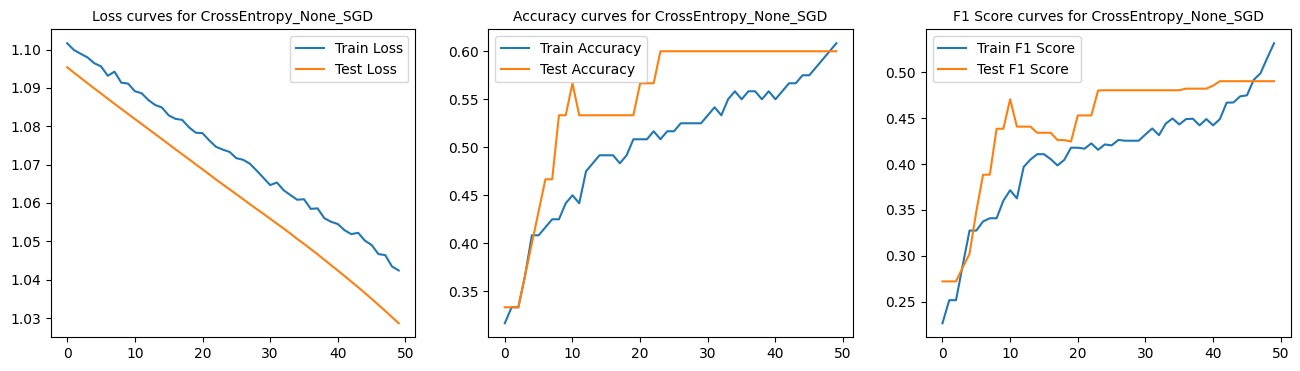

For CrossEntropy_None_SGD:
  - Training time: 0.6238 seconds
  - Final Training Accuracy: 0.6083
  - Final Test Accuracy: 0.6000
  - Final Training F1 Score: 0.5315
  - Final Test F1 Score: 0.4902



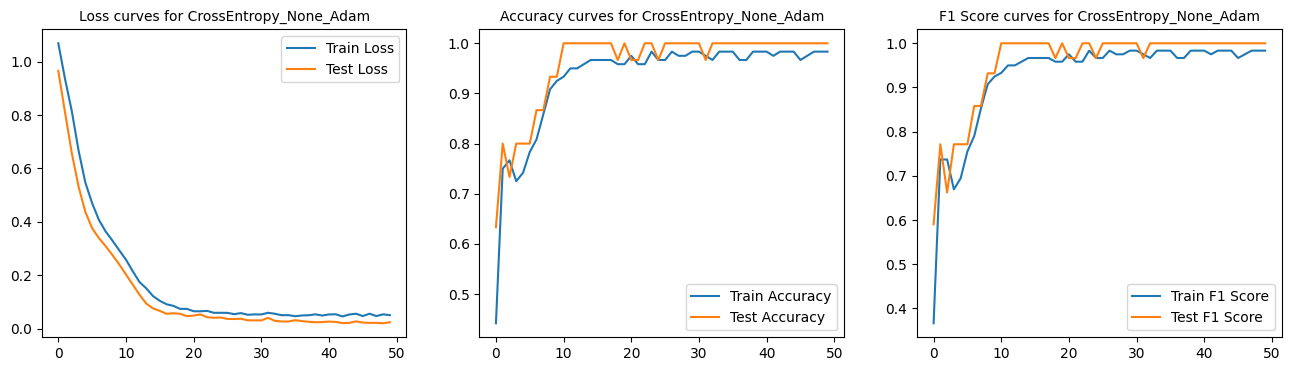

For CrossEntropy_None_Adam:
  - Training time: 0.6794 seconds
  - Final Training Accuracy: 0.9833
  - Final Test Accuracy: 1.0000
  - Final Training F1 Score: 0.9833
  - Final Test F1 Score: 1.0000



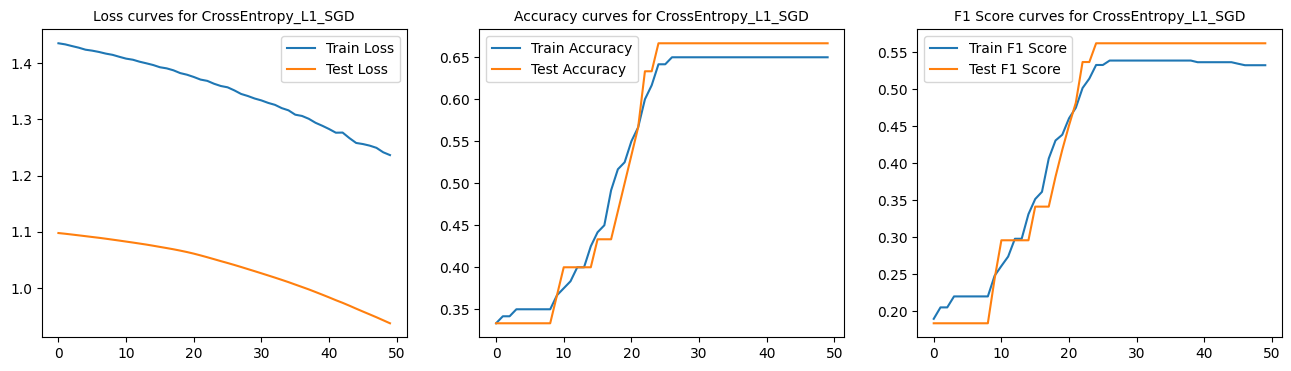

For CrossEntropy_L1_SGD:
  - Training time: 0.6857 seconds
  - Final Training Accuracy: 0.6500
  - Final Test Accuracy: 0.6667
  - Final Training F1 Score: 0.5322
  - Final Test F1 Score: 0.5619



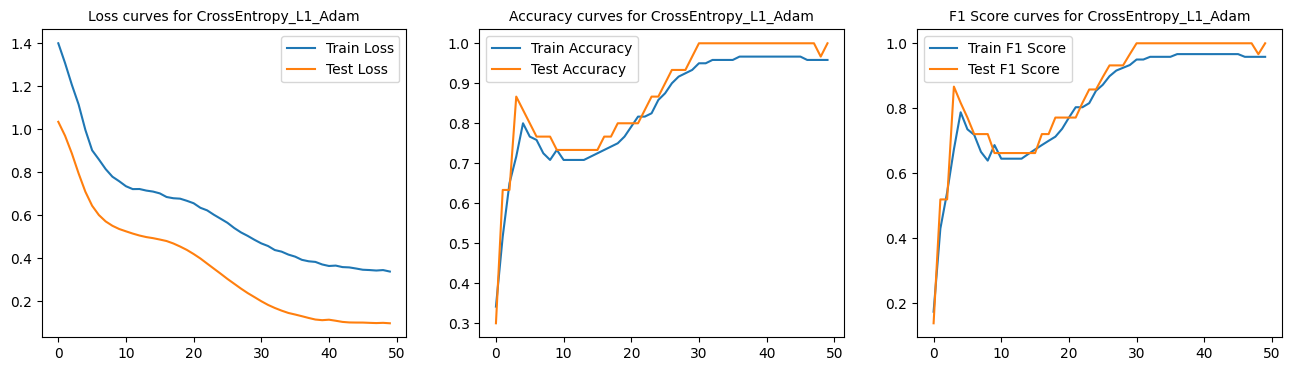

For CrossEntropy_L1_Adam:
  - Training time: 0.8190 seconds
  - Final Training Accuracy: 0.9583
  - Final Test Accuracy: 1.0000
  - Final Training F1 Score: 0.9583
  - Final Test F1 Score: 1.0000



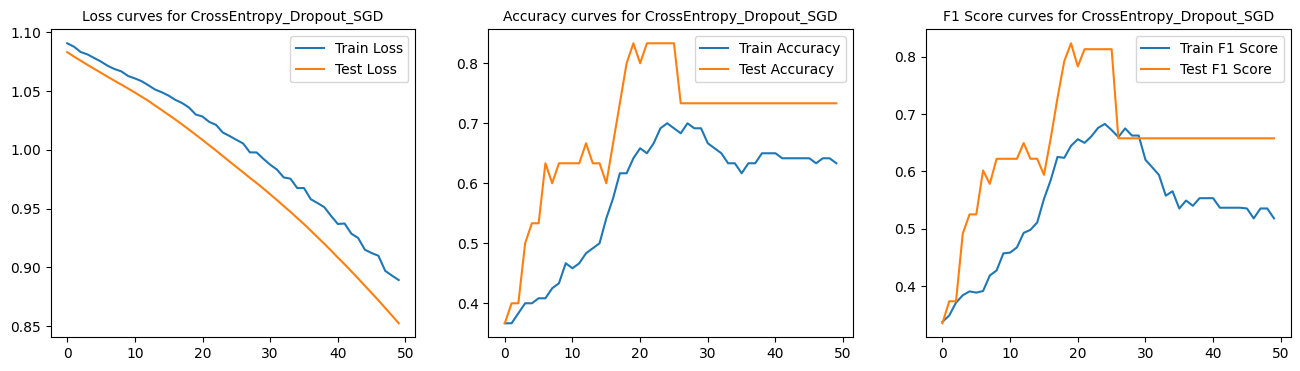

For CrossEntropy_Dropout_SGD:
  - Training time: 0.8862 seconds
  - Final Training Accuracy: 0.6333
  - Final Test Accuracy: 0.7333
  - Final Training F1 Score: 0.5179
  - Final Test F1 Score: 0.6576



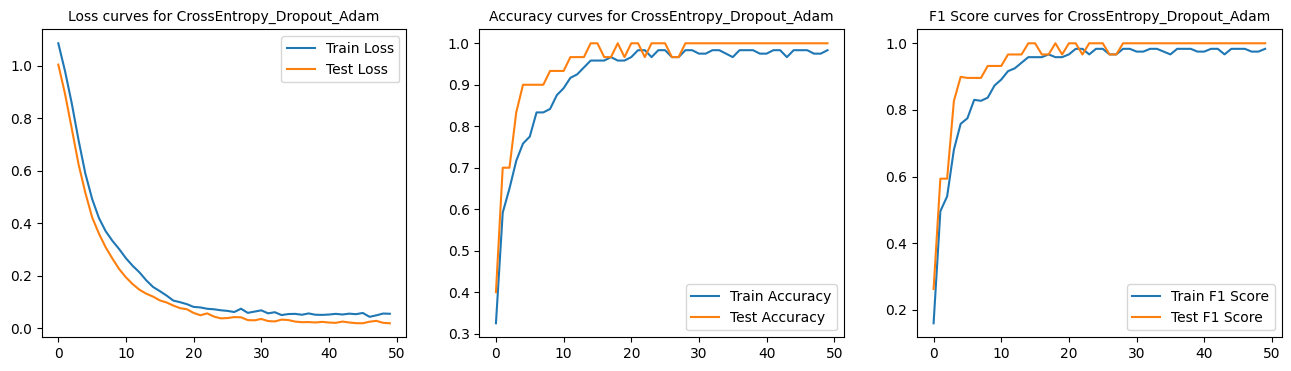

For CrossEntropy_Dropout_Adam:
  - Training time: 0.8637 seconds
  - Final Training Accuracy: 0.9833
  - Final Test Accuracy: 1.0000
  - Final Training F1 Score: 0.9833
  - Final Test F1 Score: 1.0000



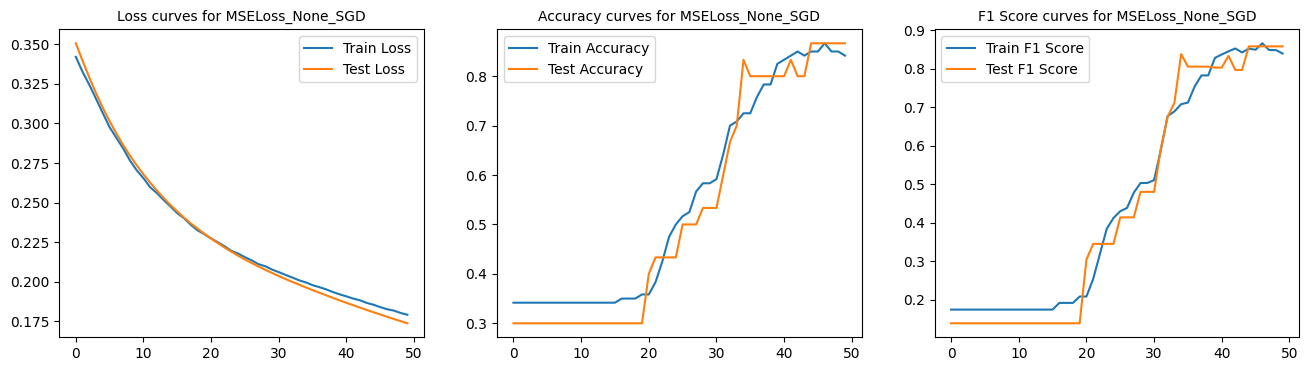

For MSELoss_None_SGD:
  - Training time: 0.7561 seconds
  - Final Training Accuracy: 0.8417
  - Final Test Accuracy: 0.8667
  - Final Training F1 Score: 0.8393
  - Final Test F1 Score: 0.8579



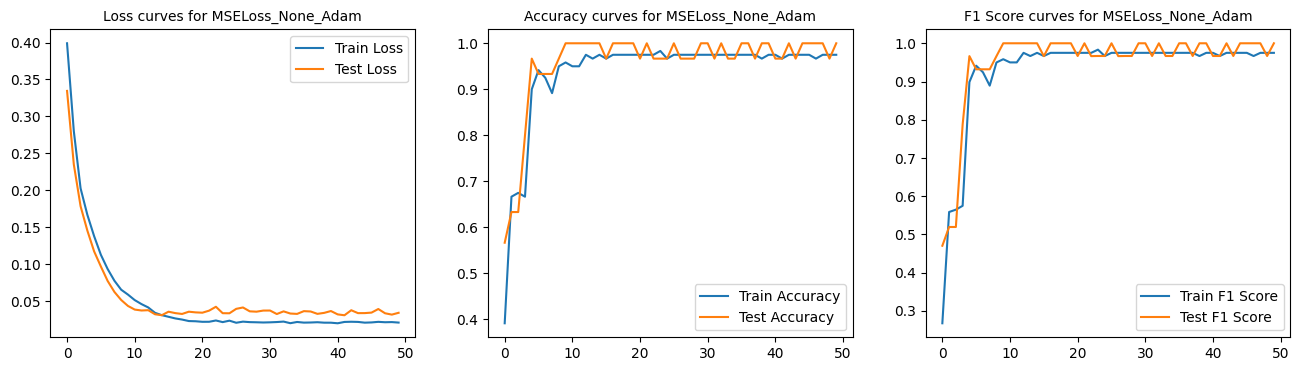

For MSELoss_None_Adam:
  - Training time: 0.7115 seconds
  - Final Training Accuracy: 0.9750
  - Final Test Accuracy: 1.0000
  - Final Training F1 Score: 0.9750
  - Final Test F1 Score: 1.0000



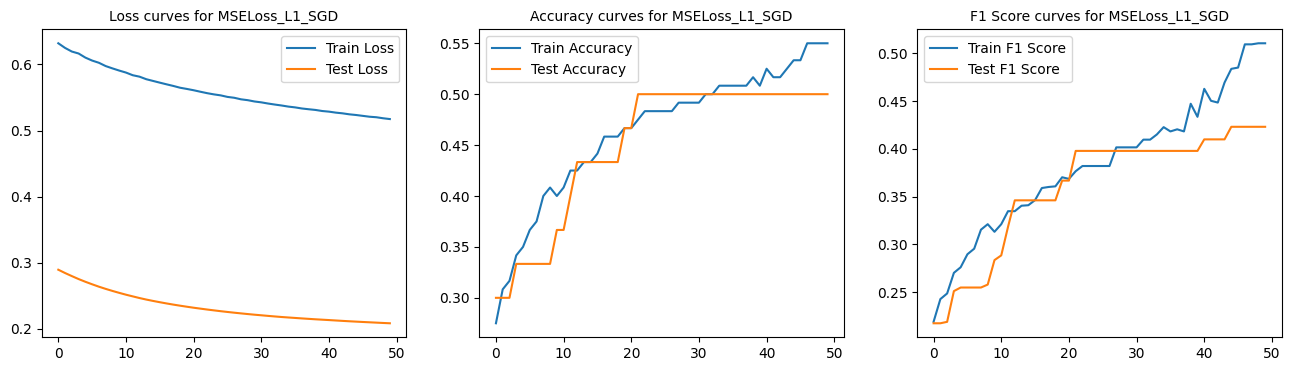

For MSELoss_L1_SGD:
  - Training time: 1.0380 seconds
  - Final Training Accuracy: 0.5500
  - Final Test Accuracy: 0.5000
  - Final Training F1 Score: 0.5105
  - Final Test F1 Score: 0.4230



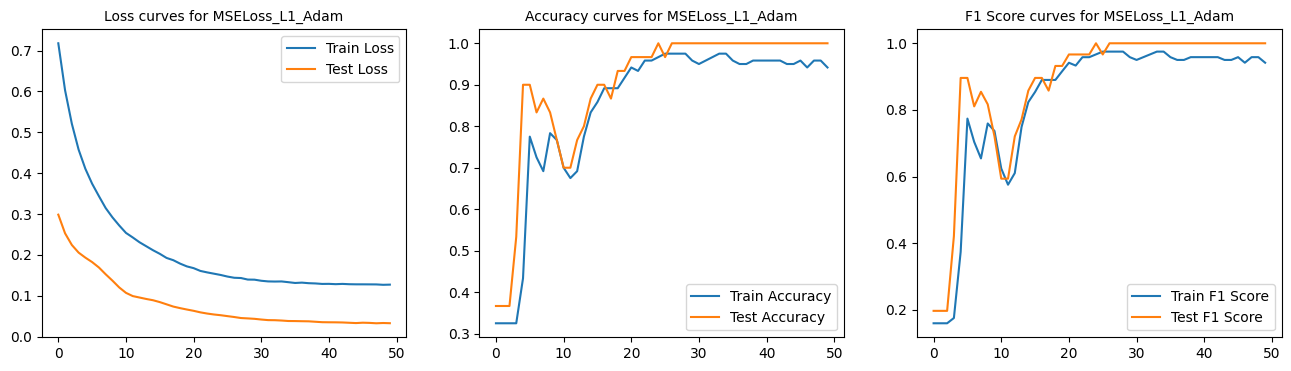

For MSELoss_L1_Adam:
  - Training time: 0.8428 seconds
  - Final Training Accuracy: 0.9417
  - Final Test Accuracy: 1.0000
  - Final Training F1 Score: 0.9416
  - Final Test F1 Score: 1.0000



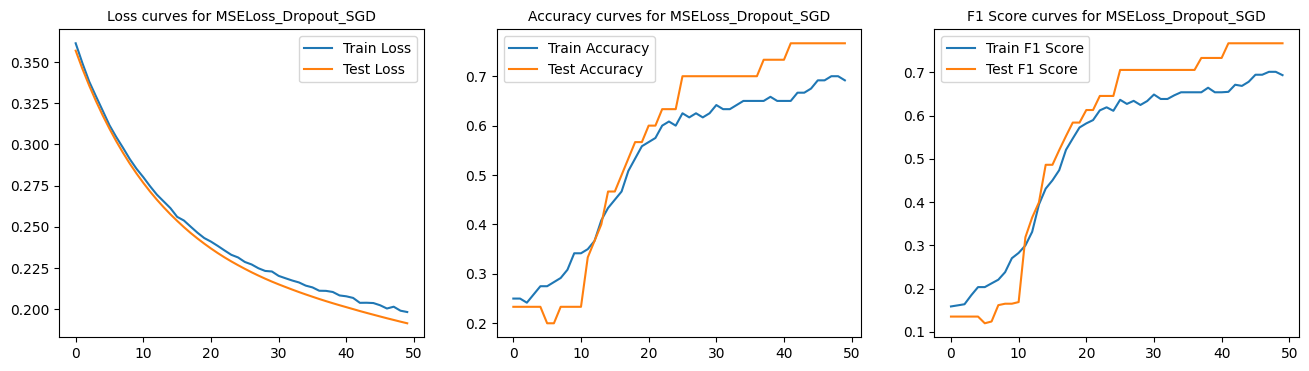

For MSELoss_Dropout_SGD:
  - Training time: 0.6141 seconds
  - Final Training Accuracy: 0.6917
  - Final Test Accuracy: 0.7667
  - Final Training F1 Score: 0.6936
  - Final Test F1 Score: 0.7673



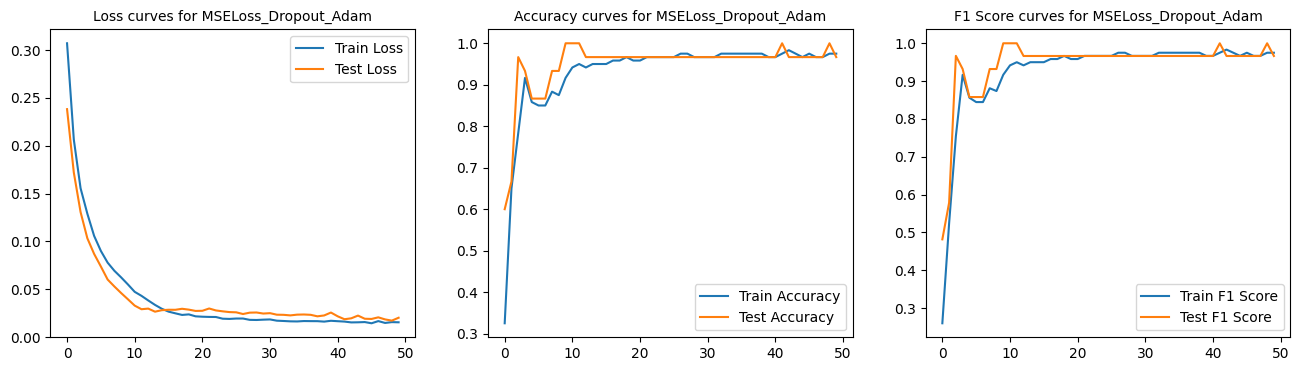

For MSELoss_Dropout_Adam:
  - Training time: 1.1175 seconds
  - Final Training Accuracy: 0.9750
  - Final Test Accuracy: 0.9667
  - Final Training F1 Score: 0.9750
  - Final Test F1 Score: 0.9664



In [59]:
results = []

# Probar 
for loss_name, criterion in loss_functions.items():
    for reg_name, reg_params in regularization.items():
        for opt_name, opt_class in optimizers.items():
            config_name = f"{loss_name}_{reg_name}_{opt_name}"
            # Construir modelo
            model = None
            if reg_params["dropout"] > 0:
                model = SimpleFeedForwardNN()
            else:
                model = RegularizedFeedForwardNN(dropout_rate=reg_params["dropout"])
            optimizer = opt_class(model.parameters(), lr=0.01, weight_decay=reg_params['weight_decay'])
            train_loss, val_loss = [], []
            train_accuracy, val_accuracy = [], []
            train_f1, val_f1 = [], []
            start_time = time.time()

            for epoch in range(50):
                # Entrenar modelo
                model.train()
                epoch_train_loss = 0
                y_true_train, y_pred_train = [], []
                for inputs, targets in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    # Aplicar One-Hot Encoding si es necesarop
                    if loss_name in ["MSELoss", "SmoothL1Loss"]:
                        criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                    else:
                        criterion_targets = targets
                    # Aplicar la regularización L1 si es pertinente
                    loss = criterion(outputs, criterion_targets)
                    if reg_name == "L1":
                        l1_loss = sum(torch.sum(torch.abs(param)) for param in model.parameters())
                        loss += reg_params.get('lambda_l1', 0.01) * l1_loss
                    loss.backward()
                    optimizer.step()
                    epoch_train_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    y_true_train.extend(targets.tolist())
                    y_pred_train.extend(predicted.tolist())

                train_loss.append(epoch_train_loss / len(train_loader))
                train_accuracy.append(accuracy_score(y_true_train, y_pred_train))
                train_f1.append(f1_score(y_true_train, y_pred_train, average='weighted'))

                # Evaluar el modelo con el conjunto de pruebas
                model.eval()
                epoch_val_loss = 0
                y_true_val, y_pred_val = [], []
                with torch.no_grad():
                    for inputs, targets in test_loader:
                        outputs = model(inputs)
                        if loss_name in ["MSELoss", "SmoothL1Loss"]:
                            criterion_targets = torch.nn.functional.one_hot(targets, 3).float()
                        else:
                            criterion_targets = targets
                        loss = criterion(outputs, criterion_targets)
                        epoch_val_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        y_true_val.extend(targets.tolist())
                        y_pred_val.extend(predicted.tolist())

                val_loss.append(epoch_val_loss / len(test_loader))
                val_accuracy.append(accuracy_score(y_true_val, y_pred_val))
                val_f1.append(f1_score(y_true_val, y_pred_val, average='weighted'))
            
            # Obtener tiempo de entrenamiento
            end_time = time.time()
            total_time = end_time - start_time
            
            # Recopilar y almacenar resultado
            result = {
                'Configuration': config_name,
                'Train Loss': train_loss[-1],
                'Test Loss': val_loss[-1],
                'Train Accuracy': train_accuracy[-1],
                'Test Accuracy': val_accuracy[-1],
                'Train F1 Score': train_f1[-1],
                'Test F1 Score': val_f1[-1],
                'Training Time (s)': total_time
            }
            results.append(result)
            
            # Visualizar las curvas
            plt.figure(figsize=(16, 4))
            plt.subplot(1, 3, 1)
            plt.plot(train_loss, label='Train Loss')
            plt.plot(val_loss, label='Test Loss')
            plt.title(f'Loss curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(train_accuracy, label='Train Accuracy')
            plt.plot(val_accuracy, label='Test Accuracy')
            plt.title(f'Accuracy curves for {config_name}',  fontsize=10)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(train_f1, label='Train F1 Score')
            plt.plot(val_f1, label='Test F1 Score')
            plt.title(f'F1 Score curves for {config_name}',  fontsize=10)
            plt.legend()
            plt.show()
            
            # Imprimir resultados por combinación
            print(f"For {config_name}:")
            print(f"  - Training time: {total_time:.4f} seconds")
            print(f"  - Final Training Accuracy: {train_accuracy[-1]:.4f}")
            print(f"  - Final Test Accuracy: {val_accuracy[-1]:.4f}")
            print(f"  - Final Training F1 Score: {train_f1[-1]:.4f}")
            print(f"  - Final Test F1 Score: {val_f1[-1]:.4f}")
            print()


In [60]:
# Desplegar resultados como dataframe
results_df = pd.DataFrame(results)
display(results_df)

,Configuration,Train Loss,Test Loss,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score,Training Time (s)
0,CrossEntropy_None_SGD,1.042385,1.028610,0.608333,0.600000,0.531489,0.490171,0.623836
1,CrossEntropy_None_Adam,0.050320,0.023884,0.983333,1.000000,0.983333,1.000000,0.679445
2,CrossEntropy_L1_SGD,1.236523,0.937758,0.650000,0.666667,0.532243,0.561905,0.685675
3,CrossEntropy_L1_Adam,0.337097,0.096465,0.958333,1.000000,0.958314,1.000000,0.818986
4,CrossEntropy_Dropout_SGD,0.889316,0.852572,0.633333,0.733333,0.517916,0.657638,0.886171
5,CrossEntropy_Dropout_Adam,0.054737,0.018499,0.983333,1.000000,0.983333,1.000000,0.863680
6,MSELoss_None_SGD,0.179224,0.173848,0.841667,0.866667,0.839307,0.857875,0.756084
7,MSELoss_None_Adam,0.020762,0.034013,0.975000,1.000000,0.974988,1.000000,0.711531
8,MSELoss_L1_SGD,0.517323,0.208261,0.550000,0.500000,0.510525,0.423030,1.038042
9,MSELoss_L1_Adam,0.127091,0.032630,0.941667,1.000000,0.941639,1.000000,0.842764


C:\Users\Alejandro\AppData\Local\Temp\ipykernel_17460\948479654.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Configuration', y='Test Accuracy', palette=clrs)


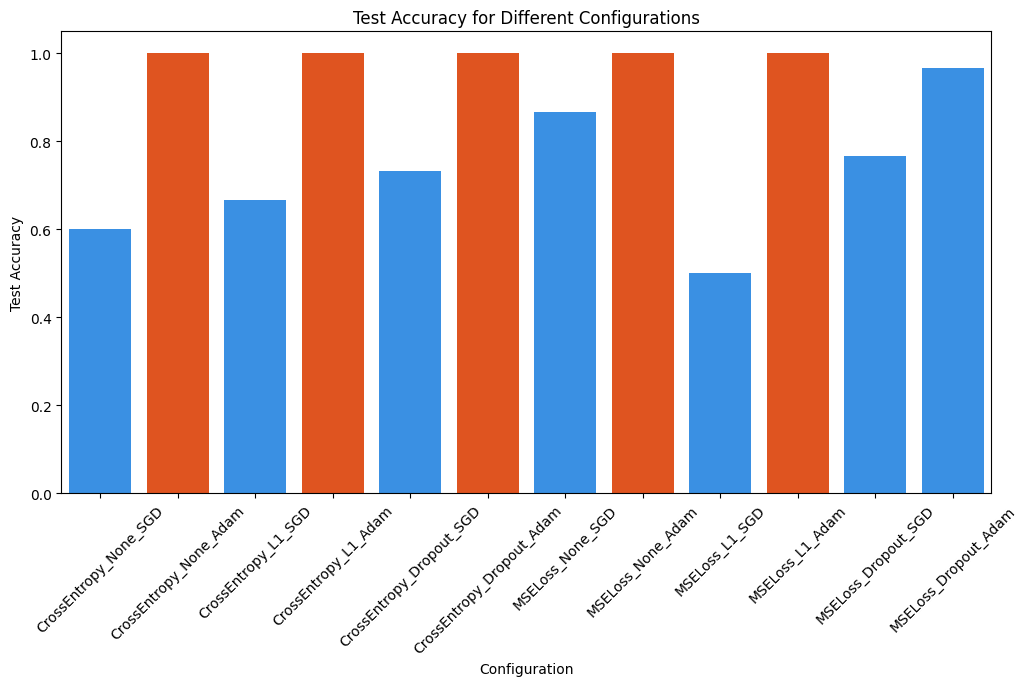

In [80]:
# Visualizar configuraciones con mayor precisión en el conjunto de pruebas
plt.figure(figsize=(12,6))
clrs = ['orangered' if x == 1.0 else 'dodgerblue' for x in results_df["Test Accuracy"]] # Colorear valores = 1.0 con rojo
sns.barplot(data=results_df, x='Configuration', y='Test Accuracy', palette=clrs)
plt.xticks(rotation=45)
plt.title('Test Accuracy for Different Configurations')
plt.show()

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_17460\489832466.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Configuration', y='Test F1 Score', palette=clrs)


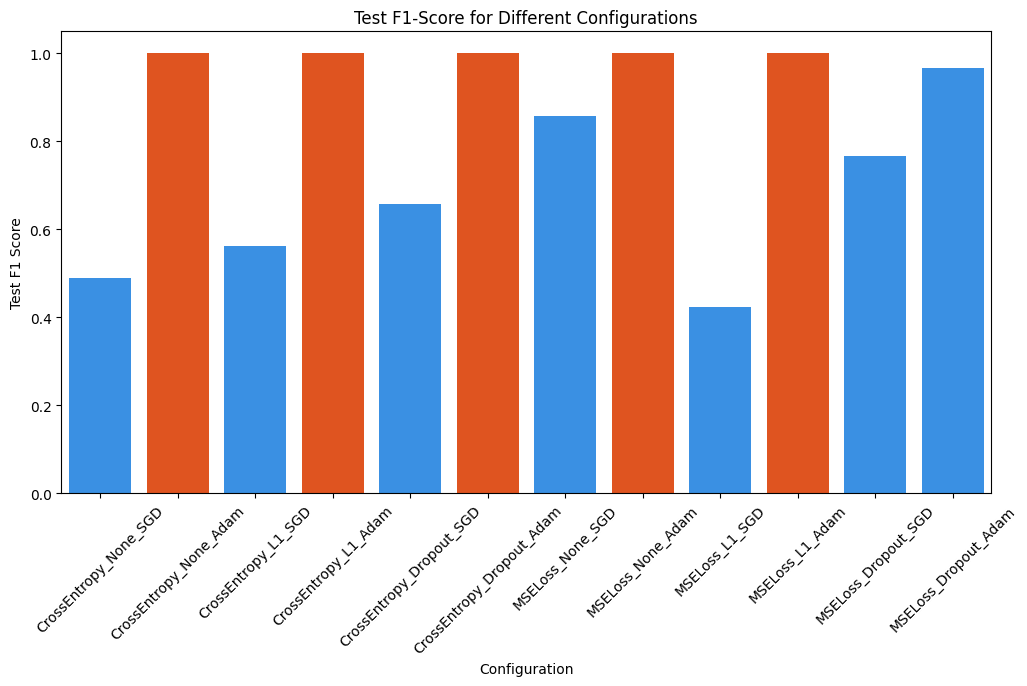

In [82]:
# Visualizar configuraciones con mayor F1-Score en el conjunto de pruebas
plt.figure(figsize=(12,6))
clrs = ['orangered' if x == max(results_df["Test F1 Score"]) else 'dodgerblue' for x in results_df["Test F1 Score"]] # Colorear máximos con rojo
sns.barplot(data=results_df, x='Configuration', y='Test F1 Score', palette=clrs)
plt.xticks(rotation=45)
plt.title('Test F1-Score for Different Configurations')
plt.show()

# Task 7

En la Task 6, se observó que los modelos que utilizan el optimizador Adam superaron consistentemente a SGD en términos de la velocidad de convergencia y en el rendimiento final, especialmente cuando se combinó con CrossEntropy Loss y Dropout. Esta configuración resultó ser la más efectiva, obteniendo una baja pérdida final y un alto valor de precisión para los datos de pruebas. Por otro lado, L1 Regularization no mostró beneficios claros para el conjunto de datos utilizado, a menudo resultando en un menor rendimiento y mayor pérdida final, lo que indica que la “esparsidad” forzada por la pérdida L1 pudo haber sido contraproducente.

En general, CrossEntropy Loss se adapta mejor a tareas de clasificación y, combinada con Adam y Dropout, proporciona una configuración robusta que mantiene el balance entre la precisión y la prevención del sobreajuste. Los modelos con MSELoss y L1 Regularization, no fueron tan efectivos para el conjunto de datos.